# Proyek Klasifikasi Gambar: [[Brain Cancer - MRI Dataset](https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset)]
- **Nama:** [Muhammad Faris Kurniawan]
- **Email:** [Farisfurqon2881@gmail.com]
- **ID Dicoding:** [awan_rmn]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fariskurniawan","key":"66d11aa157fa8eba30e3333b958da435"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d orvile/brain-cancer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset
License(s): CC-BY-SA-4.0
 82% 119M/144M [00:00<00:00, 1.24GB/s]
100% 144M/144M [00:00<00:00, 1.15GB/s]


In [5]:
!unzip -q brain-cancer-mri-dataset.zip \
  && rm brain-cancer-mri-dataset.zip

### Data Preprocessing

#### Split Dataset

In [6]:
# Tentukan path dataset
dataset_path = "Brain_Cancer raw MRI data/Brain_Cancer"

# List label berdasarkan folder
class_names = os.listdir(dataset_path)
print("Kelas yang tersedia:", class_names)

# Set image size & path
IMG_SIZE = 224
data = []
labels = []

# Load dan resize gambar
for label in class_names:
    folder = os.path.join(dataset_path, label)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(label)
        except:
            print(f"Error loading image: {img_path}")

# Konversi ke numpy array
X = np.array(data) / 255.0
y = pd.get_dummies(labels).values


Kelas yang tersedia: ['brain_menin', 'brain_tumor', 'brain_glioma']


Karena tidak bisa membagi langsung file tersebut menjadi train, validation, dan test (karena selalu ada note (*Your session crashed after using all available RAM*). Oleh sebab itu, alternatif nya seperti ini

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dir = "Brain_Cancer raw MRI data/Brain_Cancer"
base_dir = "brain_cancer_dataset"
os.makedirs(base_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    for cls in os.listdir(original_dir):
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

for cls in os.listdir(original_dir):
    class_path = os.path.join(original_dir, cls)
    images = os.listdir(class_path)
    train_imgs, test_imgs = train_test_split(images, test_size=0.15, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.15, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'val', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(base_dir, 'test', cls, img))

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
class_names = list(train_generator.class_indices.keys())

Found 4373 images belonging to 3 classes.
Found 773 images belonging to 3 classes.
Found 910 images belonging to 3 classes.


## Modelling

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,826,627 (37.49 MB)

 Trainable params: 9,826,627 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.5110 - loss: 0.9539

137/137 ━━━━━━━━━━━━━━━━━━━━ 90s 592ms/step - accuracy: 0.5116 - loss: 0.9530 - val_accuracy: 0.6805 - val_loss: 0.7211 - learning_rate: 5.0000e-04
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6915 - loss: 0.6921

137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 520ms/step - accuracy: 0.6916 - loss: 0.6919 - val_accuracy: 0.7245 - val_loss: 0.6591 - learning_rate: 5.0000e-04
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7494 - loss: 0.5971

137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 519ms/step - accuracy: 0.7494 - loss: 0.5971 - val_accuracy: 0.8111 - val_loss: 0.5215 - learning_rate: 5.0000e-04
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7795 - loss: 0.5347

137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 510ms/step - accuracy: 0.7795 - loss: 0.5347 - val_accuracy: 0.8305 - val_loss: 0.4478 - learning_rate: 5.0000e-04
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8104 - loss: 0.4989

137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 522ms/step - accuracy: 0.8103 - loss: 0.4989 - val_accuracy: 0.8344 - val_loss: 0.4451 - learning_rate: 5.0000e-04
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8055 - loss: 0.4769

137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 508ms/step - accuracy: 0.8055 - loss: 0.4768 - val_accuracy: 0.8473 - val_loss: 0.4151 - learning_rate: 5.0000e-04
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.8163 - loss: 0.4543

137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 510ms/step - accuracy: 0.8164 - loss: 0.4543 - val_accuracy: 0.8435 - val_loss: 0.3894 - learning_rate: 5.0000e-04
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8368 - loss: 0.4064

137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 518ms/step - accuracy: 0.8368 - loss: 0.4064 - val_accuracy: 0.8642 - val_loss: 0.3700 - learning_rate: 5.0000e-04
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8582 - loss: 0.3526

137/137 ━━━━━━━━━━━━━━━━━━━━ 81s 508ms/step - accuracy: 0.8583 - loss: 0.3526 - val_accuracy: 0.8810 - val_loss: 0.3282 - learning_rate: 5.0000e-04
Epoch 10/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8683 - loss: 0.3310

137/137 ━━━━━━━━━━━━━━━━━━━━ 85s 530ms/step - accuracy: 0.8683 - loss: 0.3309 - val_accuracy: 0.9017 - val_loss: 0.2703 - learning_rate: 5.0000e-04
Epoch 11/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 80s 515ms/step - accuracy: 0.8797 - loss: 0.3060 - val_accuracy: 0.8693 - val_loss: 0.3679 - learning_rate: 5.0000e-04
Epoch 12/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8972 - loss: 0.2623

137/137 ━━━━━━━━━━━━━━━━━━━━ 73s 529ms/step - accuracy: 0.8972 - loss: 0.2623 - val_accuracy: 0.9017 - val_loss: 0.2416 - learning_rate: 5.0000e-04
Epoch 13/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 500ms/step - accuracy: 0.9077 - loss: 0.2293 - val_accuracy: 0.9082 - val_loss: 0.2483 - learning_rate: 5.0000e-04
Epoch 14/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9353 - loss: 0.1713

137/137 ━━━━━━━━━━━━━━━━━━━━ 75s 547ms/step - accuracy: 0.9352 - loss: 0.1714 - val_accuracy: 0.9314 - val_loss: 0.1689 - learning_rate: 5.0000e-04
Epoch 15/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 523ms/step - accuracy: 0.9355 - loss: 0.1717 - val_accuracy: 0.8745 - val_loss: 0.3144 - learning_rate: 5.0000e-04
Epoch 16/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 522ms/step - accuracy: 0.9453 - loss: 0.1601 - val_accuracy: 0.9237 - val_loss: 0.1978 - learning_rate: 5.0000e-04
Epoch 17/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 511ms/step - accuracy: 0.9385 - loss: 0.1619 - val_accuracy: 0.9263 - val_loss: 0.1745 - learning_rate: 5.0000e-04
Epoch 18/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9617 - loss: 0.1050

137/137 ━━━━━━━━━━━━━━━━━━━━ 84s 611ms/step - accuracy: 0.9617 - loss: 0.1049 - val_accuracy: 0.9534 - val_loss: 0.1462 - learning_rate: 1.0000e-04
Epoch 19/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 519ms/step - accuracy: 0.9758 - loss: 0.0694 - val_accuracy: 0.9444 - val_loss: 0.1562 - learning_rate: 1.0000e-04
Epoch 20/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9736 - loss: 0.0735

137/137 ━━━━━━━━━━━━━━━━━━━━ 78s 566ms/step - accuracy: 0.9736 - loss: 0.0735 - val_accuracy: 0.9573 - val_loss: 0.1271 - learning_rate: 1.0000e-04
Epoch 21/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 75s 513ms/step - accuracy: 0.9749 - loss: 0.0648 - val_accuracy: 0.9457 - val_loss: 0.1659 - learning_rate: 1.0000e-04
Epoch 22/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9767 - loss: 0.0703

137/137 ━━━━━━━━━━━━━━━━━━━━ 77s 559ms/step - accuracy: 0.9767 - loss: 0.0703 - val_accuracy: 0.9599 - val_loss: 0.1259 - learning_rate: 1.0000e-04
Epoch 23/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 517ms/step - accuracy: 0.9785 - loss: 0.0561 - val_accuracy: 0.9586 - val_loss: 0.1488 - learning_rate: 1.0000e-04
Epoch 24/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 82s 515ms/step - accuracy: 0.9735 - loss: 0.0616 - val_accuracy: 0.9444 - val_loss: 0.1546 - learning_rate: 1.0000e-04
Epoch 25/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 513ms/step - accuracy: 0.9776 - loss: 0.0580 - val_accuracy: 0.9521 - val_loss: 0.1388 - learning_rate: 1.0000e-04
Epoch 26/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 505ms/step - accuracy: 0.9825 - loss: 0.0502 - val_accuracy: 0.9495 - val_loss: 0.1419 - learning_rate: 2.0000e-05
Epoch 27/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 517ms/step - accuracy: 0.9846 - loss: 0.0461 - val_accuracy: 0.9547 - val_loss: 0.1407 - learning_rate: 2.0000e-05
Epoch 28/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 501ms/s

## Evaluasi dan Visualisasi

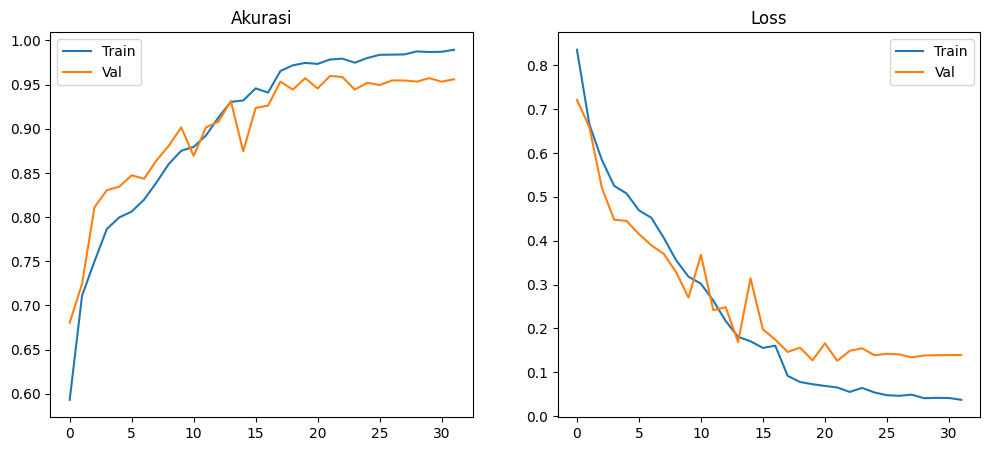

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Akurasi')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()

In [12]:
# Print akurasi terakhir dari training dan validation set
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
loss, test_accuracy = model.evaluate(test_generator)

print(f"Akurasi akhir Training: {final_train_acc*100:.2f}%")
print(f"Akurasi akhir Validation: {final_val_acc*100:.2f}%")
print(f"Akurasi Test Set: {test_accuracy*100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9712 - loss: 0.1170
Akurasi akhir Training: 98.95%
Akurasi akhir Validation: 95.60%
Akurasi Test Set: 96.70%


## Konversi Model

In [13]:
import os

# Buat direktori sesuai struktur submission
os.makedirs("submission/saved_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/tfjs_model", exist_ok=True)

In [14]:
# Simpan model ke SavedModel (format TensorFlow)
model.export("submission/saved_model")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140290650200336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650201296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650204176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650203024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650203600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650204944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650200720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650205328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650205712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140290650207248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14029065

In [15]:
import tensorflow as tf

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()

# Simpan model TFLite
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt
with open("submission/tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

In [19]:
# Jalankan hanya sekali di Colab
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [20]:
# Konversi SavedModel ke TFJS
!tensorflowjs_converter --input_format=tf_saved_model \
  submission/saved_model submission/tfjs_model

2025-05-17 16:07:59.947039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747498079.995801   14774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747498080.007598   14774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-17 16:08:11.708961: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747498091.709147   14774 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

Saving brain_tumor_0010.jpg to brain_tumor_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


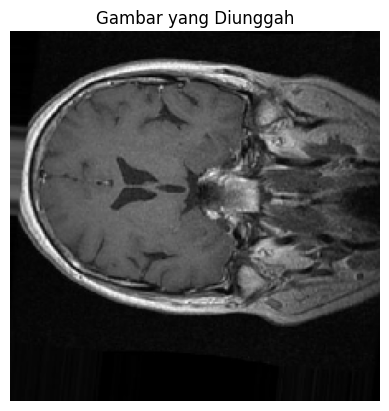

brain_glioma: 0.00%
brain_menin: 0.18%
brain_tumor: 99.82%

Hasil Prediksi:
brain_tumor: 99.82%


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image

# Jika kamu menggunakan preprocessing tambahan (misal InceptionV3), bisa sesuaikan.
# Jika tidak, cukup rescale/normalize biasa:
def preprocess_input(x):
    return x / 255.0  # Sesuai model kita yang pakai rescale=1./255

# Ambil label dari train_generator
labels = list(train_generator.class_indices.keys())

# Upload gambar
uploaded = files.upload()

for file_name in uploaded.keys():
    # Muat dan praproses gambar
    img = image.load_img(file_name, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Prediksi
    images = np.vstack([x])
    proba = model.predict(images)[0]  # ganti model2 jika kamu pakai model2

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.title("Gambar yang Diunggah")
    plt.show()

    # Tampilkan skor semua kelas
    for label, p in zip(labels, proba):
        print(f"{label}: {p*100:.2f}%")

    # Deteksi hasil terbaik
    max_index = np.argmax(proba)
    max_proba = proba[max_index]
    max_label = labels[max_index]

    print('\nHasil Prediksi:')
    if max_proba >= 0.5:
        print(f"{max_label}: {max_proba*100:.2f}%")
    else:
        print("Hasil tidak ditemukan (confidence < 50%)")


In [17]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.2
astropy-iers-data==0.2025.5.12.0.38.29
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.4.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.10.0
click==8.2.0
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet

In [21]:
!zip -r /content/submission.zip /content/submission/

  adding: content/submission/ (stored 0%)
  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/group1-shard6of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard8of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard1of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard5of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/model.json (deflated 90%)
  adding: content/submission/tfjs_model/group1-shard7of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard9of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard10of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard4of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard3of10.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard2of10.bin (deflated 7%)
  adding: content/submission/saved_model/ (stored 0%)
  adding: content/submis